## Esercizio 12.2

In questo esercizio, lavorando sul codice dell'[esercizio 12.1](my-12.1.ipynb), provo a migliorare le performance della rete modificando l'architettura della rete usando dei *convolutional layers*.
Per farlo, mi servirò di layers come:
- `Conv2D`, layer convoluzionale; legandosi al layer precedente, restituisce ancora un tipo di *shape* 2D;
- `MaxPooling2D`, riduce l'immagine in input prendendo il valore massimo di un pixel su una finestra di dimensioni fissate;
- `Dropout`, spegne alcuni neuroni per rendere più difficile l'apprendimento e più robusto il modello;
- `Flatten`, appiattisce l'input, facendo passare da una shape 2D a una monodimensionale (solo dopo questo layer quindi posso utilizzare altri layer di tipo `Dense`)
- `soft-max` alla fine, per fornire output più netti possibile.

Eseguo infine i confronti basandomi su accuratezza e loss come fatto nell'esercizio precedente.

#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

## Inizializzazione della rete

In [20]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

# ==============================================
# 1: LOAD AND PROCESS DATA
# Download the MNIST data from the web: import 
# the `mnist` module and use `load_data()`.
# It creates (pre-defined) training and test data sets.
# ==============================================
print("============================")
print("1: LOAD AND PROCESS DATA")

from tensorflow.keras.datasets import mnist

img_rows, img_cols = 28, 28 # input image dimensions (pixels) 
num_classes = 10 # output: 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape) # l'input
print('Y_train shape:', Y_train.shape) # label, ovvero gli output
print('X_test shape:', X_test.shape) # l'input
print('Y_test shape:', Y_test.shape) # label, ovvero gli output

# ==============================================
# 1.1: REFORMAT DATA
# we need to format the data in the correct shape.
# ==============================================
print("\n============================")
print("1.1: REFORMAT DATA")

'''
# reshaping could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('Before to_categorical: ')
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

# cast floats to single precision, and rescale to interval [0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('After to_categorical: ')
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
'''

#-----------------------------------------------
# you will need the following for Convolutional Neural Networks
#from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('     Before to_categorical: ')

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)

print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])
#-----------------------------------------------
# doi need to cast to single precision and rescale?
# and convert to_categorical?
# ...

# cast floats to single precision, and rescale to interval [0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('     After to_categorical: ')
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)


# ==============================================
# 2: DEFINE dNN & ITS ARCHITECTURE
# Use only `Dense` layers, for simplicity.
# ==============================================
print("\n============================")
print("2: DEFINE CDNN & ITS ARCHITECTURE")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
                                                        # I need the last 3 for Convolutional Neural Networks
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam 

opt = 'adadelta(lr1)'                                    

def create_CDNN():
    model = Sequential()                                # instantiate model
    #----------create layers-------------                                                    
    model.add(Conv2D(10, kernel_size=(5, 5),            # add first convolutional layer with 10 filters (dimensionality of output space)
                     activation='relu',
                     input_shape=input_shape))          # Keras SEquential Model can infer the correct input/output dimensions of other layers
    model.add(Conv2D(100, kernel_size=(5,5), activation='relu'))
    model.add(Dropout(0.5))                             # Dropout, spegne alcuni neuroni, con rate (0.5)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())                                # Moving towards a standard flat layer in the final part
    model.add(Dense(23, activation = 'relu'))
    model.add(Dense(num_classes, activation='softmax')) # Softmax in uscita per un risutlato più netto possibile

    #-------------compile----------------                                                    
    model.compile(loss=keras.losses.categorical_crossentropy, # note that model uses **LOSS TO OPTIMIZE** ...
                  optimizer=Adadelta(learning_rate=1),        # Galli first setting: SGD()
                  metrics=['acc'])                            # ... and metrics only to **TEST PERFORMANCE**
    return model

print('Model created and compiled successfully! Ready to train.')


1: LOAD AND PROCESS DATA
X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
X_test shape: (10000, 28, 28)
Y_test shape: (10000,)

1.1: REFORMAT DATA
     Before to_categorical: 
X_train shape:  (60000, 28, 28, 1)
Y_train shape:  (60000,)
Train samples:  60000
Test samples:  10000
     After to_categorical: 
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

2: DEFINE CDNN & ITS ARCHITECTURE
Model created and compiled successfully! Ready to train.


## Training del modello

In [21]:
# ==============================================
# 4: MODEL TRAINING
# "Minibatches train": shuffling training data 
# improves stability. Thus, we train over epochs:
# in each we use all train data divided in batches.
# ==============================================
print("\n============================")
print("4: MODEL TRAINING")

my_batch_size = 32
epochs = 10                                         # <<<<<<<<<<<<<<<<<<<<<<<<<<<<< use more than 5

model_CDNN = create_CDNN()

# Train CDNN and store training info in history
# Use the `fit()` method of the `Sequential` class
history = model_CDNN.fit(X_train, Y_train,          # input and output data
                        batch_size=my_batch_size,   # optional
                        epochs=epochs,              # optional (but how can it work without?)
                        verbose=1,                  # monitoring training process
                        validation_data=(X_test, Y_test)# optional
                        )


4: MODEL TRAINING
Epoch 1/5


2022-07-05 16:13:44.587533: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 405s 215ms/step - loss: 0.1243 - acc: 0.9625 - val_loss: 0.0579 - val_acc: 0.9853
Epoch 2/5
1875/1875 [==============================] - 399s 213ms/step - loss: 0.0434 - acc: 0.9871 - val_loss: 0.0414 - val_acc: 0.9889
Epoch 3/5
1875/1875 [==============================] - 403s 215ms/step - loss: 0.0308 - acc: 0.9908 - val_loss: 0.0345 - val_acc: 0.9899
Epoch 4/5
1875/1875 [==============================] - 399s 213ms/step - loss: 0.0249 - acc: 0.9923 - val_loss: 0.0318 - val_acc: 0.9904
Epoch 5/5
1875/1875 [==============================] - 404s 215ms/step - loss: 0.0206 - acc: 0.9939 - val_loss: 0.0267 - val_acc: 0.9915



5: MODEL PERFORMANCE EVALUATION
313/313 [==============================] - 15s 48ms/step - loss: 0.0267 - acc: 0.9915
Test loss: 0.02666957676410675
Test accuracy: 0.9915000200271606


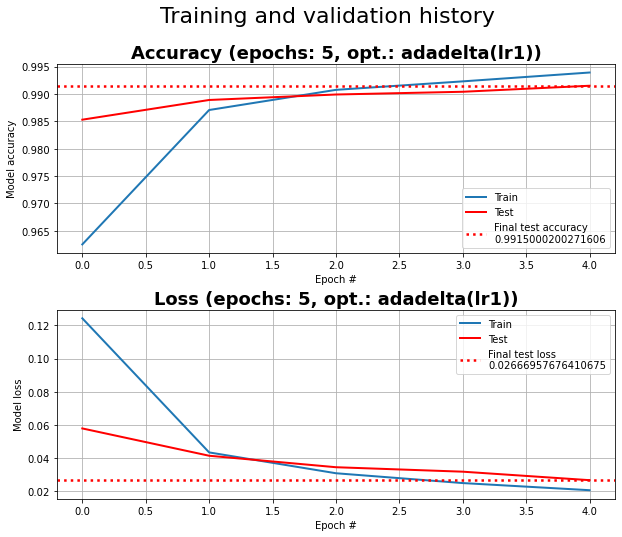


6: MODEL PREDICTIONS


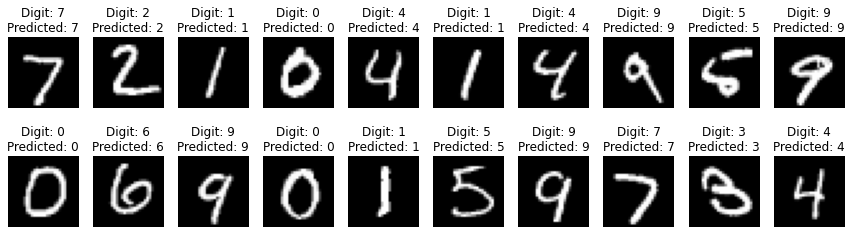

In [25]:
# ==============================================
# 5: MODEL PERFORMANCE EVALUATION
# Evaluate performance on (unseen) test data
# ==============================================
print("\n============================")
print("5: MODEL PERFORMANCE EVALUATION")

score = model_CDNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history
# summarize history for accuracy
plt.figure(figsize=(10,8))
plt.suptitle("Training and validation history", fontsize = 22)

plt.subplot(2,1,1)
plt.plot(history.history['acc'], label = 'Train', linewidth = 2)
plt.plot(history.history['val_acc'], label = 'Test', color = 'r', linewidth = 2)
finacc = history.history['val_acc'][epochs-1]
plt.axhline(y=finacc, color = 'r', label = 'Final test accuracy\n'+str(finacc), linestyle =':', linewidth = 2.5)
title = "Accuracy (epochs: "+str(epochs)+", opt.: "+opt+")"
plt.title(title, fontsize = 18, fontweight = "bold")
plt.ylabel('Model accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='best')
plt.grid()

# summarize history for loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label = 'Train', linewidth = 2)
plt.plot(history.history['val_loss'],  label = 'Test', color ='r', linewidth = 2)
finacc = history.history['val_loss'][epochs-1]
plt.axhline(y=finacc, color = 'r', label = 'Final test loss\n'+str(finacc), linestyle = ':', linewidth = 2.5)
title = "Loss (epochs: "+str(epochs)+", opt.: "+opt+")"
plt.title(title, fontsize = 18, fontweight = "bold")
plt.ylabel('Model loss')
plt.xlabel('Epoch #')
plt.legend(loc='best')
plt.grid()

plt.subplots_adjust(hspace=0.3)
plt.savefig('imgs/2/train'+str(epochs)+opt+'.png', facecolor='white')
plt.show()

# ==============================================
# 6: MODEL PREDICTIONS
# ==============================================
print("\n============================")
print("6: MODEL PREDICTIONS")
predictions = model_CDNN.predict(X_test)

x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15,4))
for i in range(20):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(x_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 

plt.savefig('imgs/2/pred'+str(epochs)+opt+'.png', facecolor='w')
plt.show()



## Confronti



Siccome il modello che ho costruito è molto lento da calibrare, ho usato inizialmente **5 epoche** (30 minuti!), mantenendo l'ottimizzatore trovato in precedenza (`adadelta`, con `LR=1`).
Con questo numero di epoche, loss e accuracy non arrivano a convergere, quindi il modello può ancora essere allenato per calibrare meglio i parametri, ma sono già davvero ottime (notare l'accuratezza al $99,15\%$!!!).

Osservare la capacità predittiva guardando questi 20 numeri a occhio non è più sensato, ma dà una piacevole sensazione di sicurezza, quindi li lascio lo stesso.   
<img src="imgs/2/train5adadelta(lr1).png" width="500"/>  
<img src="imgs/2/pred5adadelta(lr1).png" width="500"/>

Scelgo come parametro ottimale per la calibrazione **10 epoche**. I risultati sono i seguenti.  
<img src="imgs/2/train10adadelta(lr1).png" width="500"/>  
<img src="imgs/2/pred10adadelta(lr1).png" width="500"/>